<a href="https://colab.research.google.com/github/leo0622nycu/Essay/blob/main/ARIMA_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
drive.mount('/content/drive')

Monthly_Revenue = pd.read_csv('/content/drive/MyDrive/CSV/Historical_Monthly_Revenue_November_2.csv')
ARIMA_TRAIN = pd.read_csv('/content/drive/MyDrive/CSV/ARIMA_TRAIN.csv')
ARIMA_TEST = pd.read_csv('/content/drive/MyDrive/CSV/ARIMA_TEST.csv')
residuals_all = pd.read_csv('/content/drive/MyDrive/CSV/residuals_all.csv')

Mounted at /content/drive


In [2]:
data = residuals_all["revenue"]
train_data = data[:104]

test_data = data[101:]
print(train_data)
print(test_data)

0      21244.248647
1       9092.763251
2     -14493.814235
3      13116.201697
4      14455.758282
           ...     
99     10715.591750
100    24111.412934
101   -16573.766642
102     6193.616110
103    40262.918840
Name: revenue, Length: 104, dtype: float64
101   -16573.766642
102     6193.616110
103    40262.918840
104    10715.101621
105     -282.390823
106     4617.918747
107   -25094.802244
108    -4475.895095
109   -38867.856205
110   -31069.893855
111    -4090.928373
112    37845.857466
113    -4451.838020
114    11544.613254
115    13852.164942
116    -2656.490194
117    61754.215508
118   -14832.913318
119   -42330.816160
120    11778.373545
121    -9615.773223
122     9079.885375
123    30513.324189
124    23832.110576
125   -20971.082119
126    23688.127116
127    20677.758670
128    13711.569128
129    43212.963194
130    -8963.896380
Name: revenue, dtype: float64


In [3]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = train_data
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[ 21244.24864732   9092.76325092 -14493.81423508] 13116.20169715795
[  9092.76325092 -14493.81423508  13116.20169716] 14455.758282181168
[-14493.81423508  13116.20169716  14455.75828218] -6540.562657700721
[13116.20169716 14455.75828218 -6540.5626577 ] -2378.879003268288
[14455.75828218 -6540.5626577  -2378.87900327] 13353.710193225916
[-6540.5626577  -2378.87900327 13353.71019323] 8044.339912223266
[-2378.87900327 13353.71019323  8044.33991222] 2044.542772457324
[13353.71019323  8044.33991222  2044.54277246] -4632.136394114612
[ 8044.33991222  2044.54277246 -4632.13639411] -4359.763496147003
[ 2044.54277246 -4632.13639411 -4359.76349615] 13188.92187674262
[-4632.13639411 -4359.76349615 13188.92187674] -14938.799146477846
[ -4359.76349615  13188.92187674 -14938.79914648] 1656.8823828433233
[ 13188.92187674 -14938.79914648   1656.88238284] -184.98761094878137
[-14938.79914648   1656.88238284   -184.98761095] 4667.964222594193
[1656.88238284 -184.98761095 4667.96422259] -14517.9560817717

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

my_optimizer = Adam(learning_rate=1e-4)

from tensorflow.keras.callbacks import EarlyStopping

# 1. 定義 EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # 監控的指標 (這裡以 validation loss 為例)
    patience=20,                 # 耐心值: 若 val_loss 連續 20 個 epoch 不再改善，就停止訓練
    restore_best_weights=True    # 停止時，回復到最好的權重 (最低 val_loss)
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,         # 每次 LR 降低的倍率
    patience=5,         # 在多少個 epoch 內沒有改善就降低 LR
    min_lr=1e-6         # 降到何種學習率就不再降
)

# define model
model = Sequential()
model.add(Dense(4, activation='relu', input_dim=n_steps))
#model.add(Dense(1, activation='relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss='mse',metrics=['mape'])
history = model.fit(X, y, validation_split=0.2, epochs=1000, batch_size=8, callbacks=[early_stopping], verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


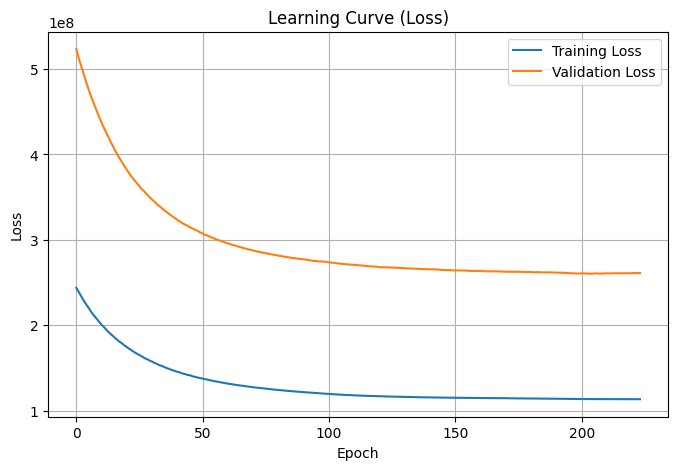

In [5]:
import matplotlib.pyplot as plt

# history.history 是一個 dict，包含以下 key:
# history.history['loss']      -> 每個 epoch 的 training loss
# history.history['val_loss']  -> 每個 epoch 的 validation loss
# history.history['mape']      -> 每個 epoch 的 training MAPE (如果有 metrics=['mape'])
# history.history['val_mape']  -> 每個 epoch 的 validation MAPE (如果有 metrics=['mape'])

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curve (Loss)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import matplotlib.pyplot as plt

# 假設 X, y 是你的訓練集 (由 split_sequence() 產生)
# 訓練完成後：
y_pred_train = model.predict(X)  # 模型在訓練集上的預測




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


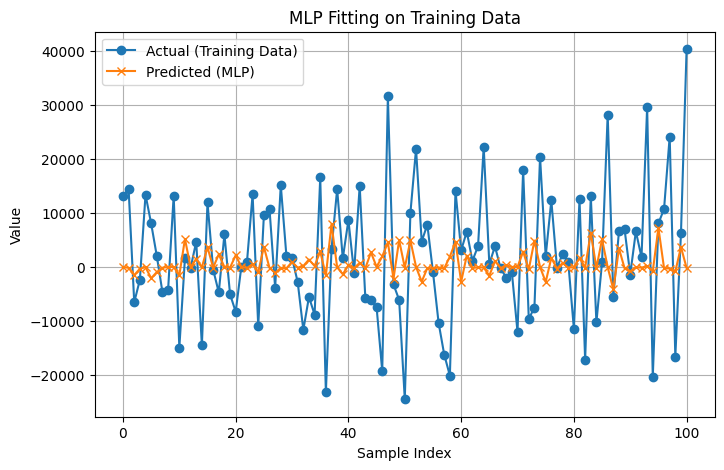

[ 5.1854974e-01 -1.7604752e+02 -1.5025491e+03 -3.4320239e+02
 -4.3077427e+01 -2.0947864e+03 -9.5192688e+02 -1.5552747e+02
 -3.7987692e+00  7.3366719e-01 -1.5231970e+03  5.1724487e+03
 -5.1830070e+01  1.5134275e+03 -7.1730232e+01  3.6362756e+03
 -1.2853400e+02  2.3311741e+03 -1.9676353e+01 -1.3180589e+02
  2.1594805e+03  7.3366719e-01 -1.9409729e+02  5.2295630e+02
 -9.8663257e+02  3.7094583e+03 -1.7430835e+02 -1.1147703e+03
 -1.8117233e+02 -2.5947165e+02  9.1725391e+02 -1.3734727e+02
  1.8261491e+02  1.3694445e+03  1.7466682e+02  2.8559011e+03
 -1.5851740e+03  7.9150796e+03 -6.2699734e+01 -1.3482029e+03
  2.9661874e+02 -2.2303621e+02  7.5376300e+02 -2.5480937e+02
  2.6947000e+03 -1.0288494e+00  1.9442061e+03  4.5319399e+03
 -2.1707288e+03  4.9441099e+03 -1.2993015e+02  4.8936206e+03
  7.3366719e-01 -2.7244802e+03 -2.2506384e+02 -2.7858328e+02
 -1.0893170e+02 -2.6957034e+02  1.9091345e+03  4.6580352e+03
 -2.7503086e+03  2.1001096e+03 -1.9896599e+02 -6.3193413e+01
 -1.0132896e+02 -1.60904

In [7]:
plt.figure(figsize=(8, 5))

# 實際值 (y) 本身就是 1D 的陣列
plt.plot(range(len(y)), y, marker='o', label='Actual (Training Data)')

# 預測值 (y_pred_train) 可能是 2D，先壓平成 1D
y_pred_train_1d = y_pred_train.flatten()
plt.plot(range(len(y_pred_train_1d)), y_pred_train_1d, marker='x', label='Predicted (MLP)')

plt.title('MLP Fitting on Training Data')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

print(y_pred_train_1d)


In [8]:
#開始預測

# 假設 n_steps 與訓練階段相同 (即 2)
n_steps = 3

# 先將 test_data 轉成 array 型態 (若原本是 Series 也可直接丟，但建議顯式轉換)
test_seq = test_data.values

# 使用相同的 split_sequence 函式做切分
X_test, y_test = split_sequence(test_seq, n_steps)
print(X_test)


[[-16573.76664201   6193.61610953  40262.91883992]
 [  6193.61610953  40262.91883992  10715.10162071]
 [ 40262.91883992  10715.10162071   -282.39082295]
 [ 10715.10162071   -282.39082295   4617.9187467 ]
 [  -282.39082295   4617.9187467  -25094.80224383]
 [  4617.9187467  -25094.80224383  -4475.89509462]
 [-25094.80224383  -4475.89509462 -38867.85620542]
 [ -4475.89509462 -38867.85620542 -31069.89385506]
 [-38867.85620542 -31069.89385506  -4090.92837334]
 [-31069.89385506  -4090.92837334  37845.85746564]
 [ -4090.92837334  37845.85746564  -4451.83802019]
 [ 37845.85746564  -4451.83802019  11544.61325372]
 [ -4451.83802019  11544.61325372  13852.16494209]
 [ 11544.61325372  13852.16494209  -2656.49019414]
 [ 13852.16494209  -2656.49019414  61754.21550818]
 [ -2656.49019414  61754.21550818 -14832.91331801]
 [ 61754.21550818 -14832.91331801 -42330.81615989]
 [-14832.91331801 -42330.81615989  11778.37354529]
 [-42330.81615989  11778.37354529  -9615.77322294]
 [ 11778.37354529  -9615.773222

In [9]:
# 使用訓練完成的模型進行預測
y_pred_test = model.predict(X_test)

# 如果要觀察預測值，可以壓平成 1D 後印出來
y_pred_test_1d = y_pred_test.flatten()
print("y_pred_test_1d:", y_pred_test_1d)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
y_pred_test_1d: [-6.74251709e+03 -5.63530273e+02 -3.28468140e+02 -1.35425232e+02
  5.74605908e+03  7.33667195e-01  1.17433252e+04  1.56761060e+03
  2.16212524e+03 -8.56408398e+03  4.29612842e+03 -4.03402008e+02
 -2.76288745e+03 -1.05001595e+02 -1.13147498e+03  8.63466797e+03
  7.33667195e-01 -6.15247253e+02  7.12386084e+03 -1.62515686e+02
 -4.84826562e+03 -2.20989624e+03 -7.02833069e+02 -3.93872375e+02
 -1.77359888e+03 -4.37325470e+02 -7.76621338e+02]


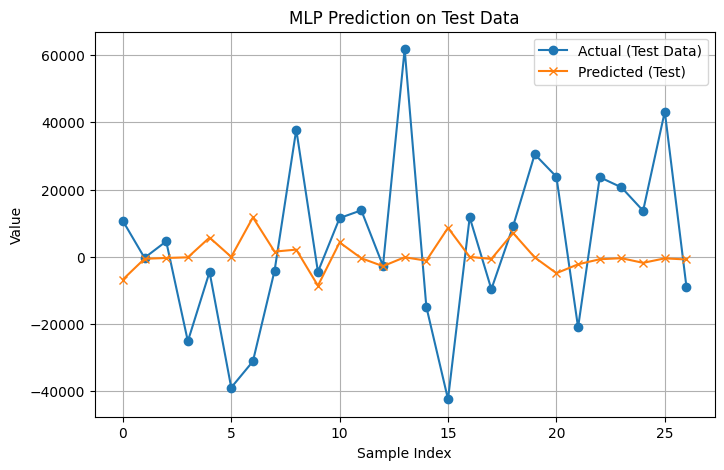

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# 實際值
plt.plot(range(len(y_test)), y_test, marker='o', label='Actual (Test Data)')

# 預測值 (1D)
plt.plot(range(len(y_pred_test_1d)), y_pred_test_1d, marker='x', label='Predicted (Test)')

plt.title('MLP Prediction on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()


In [11]:
#合成混合模型預測值
ARIMA_TRAIN_PD = ARIMA_TRAIN['predicted_mean'][3:] + y_pred_train_1d
ARIMA_TRAIN_AC = ARIMA_TRAIN['revenue'][3:]
ARIMA_TRAIN_PD = ARIMA_TRAIN_PD.reset_index(drop=True)
ARIMA_TRAIN_AC = ARIMA_TRAIN_AC.reset_index(drop=True)
print(ARIMA_TRAIN_PD)
print(ARIMA_TRAIN_AC)

0       48771.316853
1       46157.194202
2       65382.013585
3       66960.676611
4       55882.212380
           ...      
96     161614.856111
97     161290.606872
98     191605.219889
99     184242.754008
100    177686.052382
Name: predicted_mean, Length: 101, dtype: float64
0       61887.0
1       60789.0
2       60344.0
3       64925.0
4       69279.0
         ...   
96     172561.0
97     185705.0
98     175874.0
99     186763.0
100    218132.0
Name: revenue, Length: 101, dtype: float64


In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 1. 計算 RMSE
rmse = np.sqrt(mean_squared_error(ARIMA_TRAIN_AC, ARIMA_TRAIN_PD))

# 2. 計算 MAE
mae = mean_absolute_error(ARIMA_TRAIN_AC, ARIMA_TRAIN_PD)

# 3. 計算 MAPE
mape = np.mean(np.abs((ARIMA_TRAIN_AC - ARIMA_TRAIN_PD) / ARIMA_TRAIN_AC)) * 100

# 4. 輸出結果
print(f"訓練RMSE : {rmse:.2f}")
print(f"訓練MAE : {mae:.2f}")
print(f"訓練MAPE : {mape:.2f}%")

訓練RMSE : 12007.80
訓練MAE : 9127.71
訓練MAPE : 10.01%


In [13]:
#合成混合模型數據
ARIMA_TEST_PD = ARIMA_TEST['predicted_mean'] + y_pred_test_1d
ARIMA_TEST_AC = ARIMA_TEST['revenue']
ARIMA_TEST_PD = ARIMA_TEST_PD.reset_index(drop=True)
ARIMA_TEST_AC = ARIMA_TEST_AC.reset_index(drop=True)
print(ARIMA_TEST_PD)
print(ARIMA_TEST_AC)

0     190790.381289
1     209984.860550
2     217759.613114
3     217519.377012
4     210272.954177
5     202042.589873
6     188221.219050
7     153558.538969
8     140853.267778
9     152291.754036
10    170367.515164
11    174430.433050
12    180323.602743
13    181343.782897
14    219727.438342
15    227265.484129
16    204007.360122
17    190648.525970
18    193254.975464
19    205345.160125
20    200939.623799
21    226630.185879
22    232562.039815
23    229794.368954
24    236387.831995
25    270589.711336
26    284245.275042
Name: predicted_mean, dtype: float64
0     208248.0
1     210266.0
2     222706.0
3     192560.0
4     200051.0
5     163174.0
6     145408.0
7     147900.0
8     176537.0
9     156404.0
10    177616.0
11    188686.0
12    180430.0
13    243203.0
14    206026.0
15    176300.0
16    215785.0
17    181648.0
18    195211.0
19    236021.0
20    229620.0
21    207869.0
22    256953.0
23    250866.0
24    251873.0
25    314240.0
26    276058.0
Name: revenue, dty

In [14]:
rmse = np.sqrt(mean_squared_error(ARIMA_TEST_AC, ARIMA_TEST_PD))
mae = mean_absolute_error(ARIMA_TEST_AC, ARIMA_TEST_PD)
mape = np.mean(np.abs((ARIMA_TEST_AC - ARIMA_TEST_PD) / ARIMA_TEST_AC)) * 100

# 4. 輸出結果
print(f"RMSE : {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

RMSE : 25949.04
MAE : 20250.97
MAPE : 9.94%


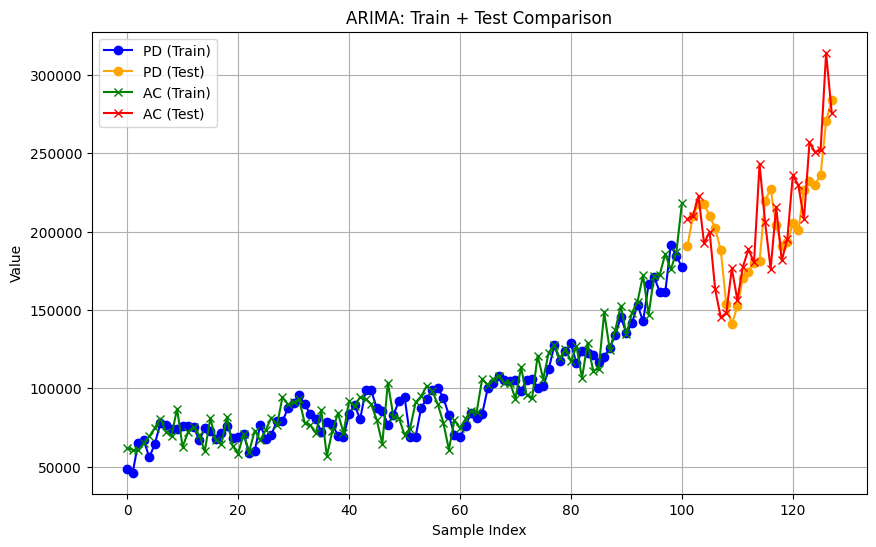

In [15]:
import matplotlib.pyplot as plt

train_len = len(ARIMA_TRAIN_PD)
test_len = len(ARIMA_TEST_PD)

# x 軸：TRAIN 部分
x_train = range(train_len)
# x 軸：TEST 部分，緊接在 train_len 之後
x_test = range(train_len, train_len + test_len)

plt.figure(figsize=(10, 6))

# 繪製預測 (Predicted) - 訓練部分 (藍色)
plt.plot(x_train, ARIMA_TRAIN_PD, color='blue', marker='o', label='PD (Train)')

# 繪製預測 (Predicted) - 測試部分 (橙色)
plt.plot(x_test, ARIMA_TEST_PD, color='orange', marker='o', label='PD (Test)')

# 繪製實際 (Actual) - 訓練部分 (綠色)
plt.plot(x_train, ARIMA_TRAIN_AC, color='green', marker='x', label='AC (Train)')

# 繪製實際 (Actual) - 測試部分 (紅色)
plt.plot(x_test, ARIMA_TEST_AC, color='red', marker='x', label='AC (Test)')

plt.title('ARIMA: Train + Test Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()
